In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re #regular  expression
import string #positioning menupulation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder #use to define phishing and benign keywords into numbers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from wordcloud import WordCloud #analyse the words frequency

In [5]:
df = pd.read_csv("malicious_phish.csv")
df.head()


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


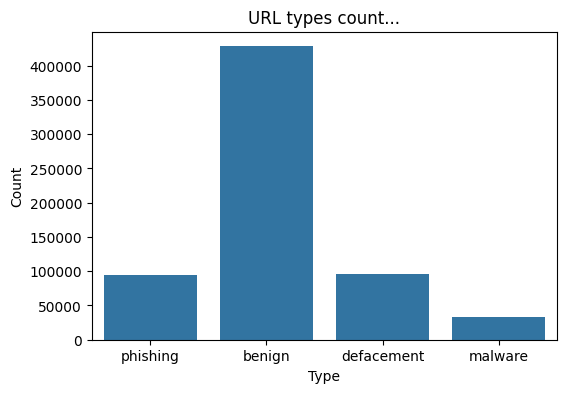

In [6]:
plt.figure(figsize = (6,4))
sns.countplot(x= 'type' , data = df)
plt.title("URL types count...")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()

Word Cloud

In [7]:
df_phish = df[df.type == 'phishing']
df_malware = df[df.type == 'malware']
df_deface= df[df.type == 'defacement']
df_benign = df[df.type == 'benign']

In [8]:
df_phish

,url,type
0,br-icloud.com.br,phishing
21,signin.eby.de.zukruygxctzmmqi.civpro.co.za,phishing
28,http://www.marketingbyinternet.com/mo/e56508df...,phishing
40,https://docs.google.com/spreadsheet/viewform?f...,phishing
72,retajconsultancy.com,phishing
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


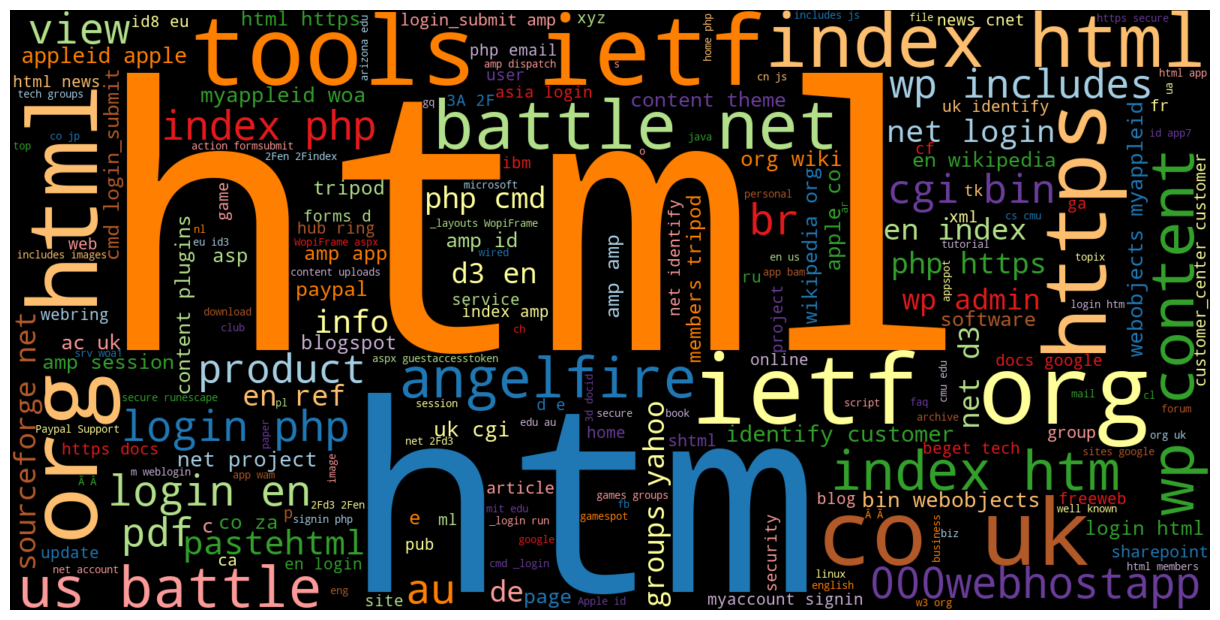

In [9]:
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width = 1600 , height = 800 , colormap = "Paired").generate(phish_url)
plt.figure(figsize=(12,13), facecolor ='w')
plt.imshow(wordcloud , interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

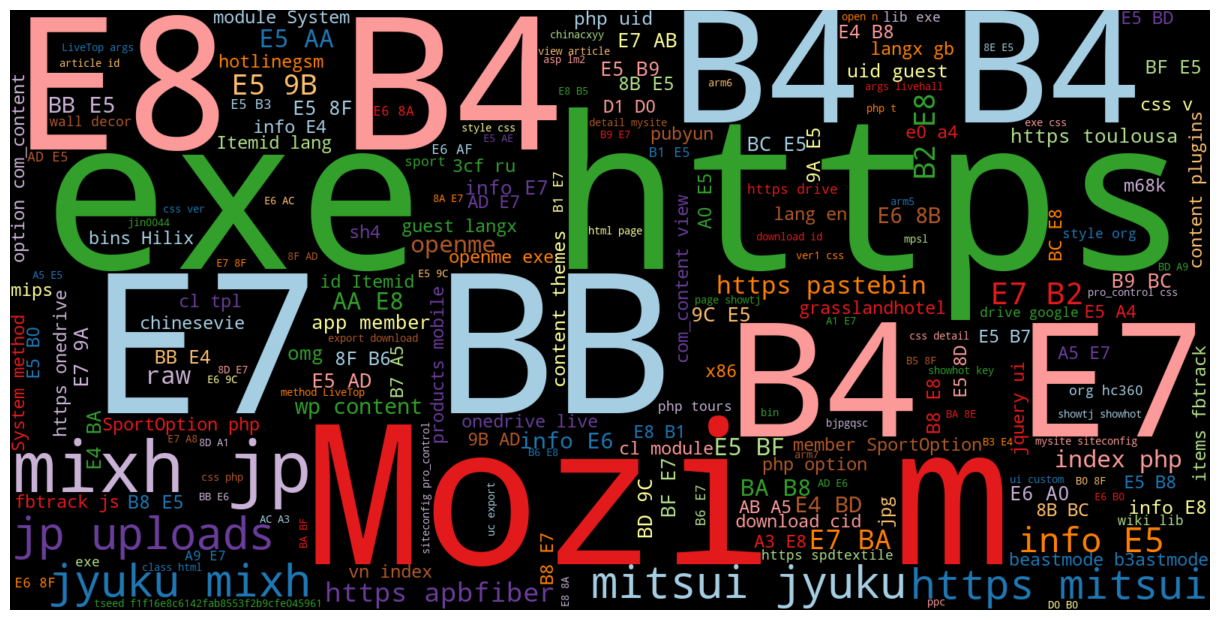

In [10]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width = 1600 , height = 800 , colormap = "Paired").generate(malware_url)
plt.figure(figsize=(12,13), facecolor ='w')
plt.imshow(wordcloud , interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

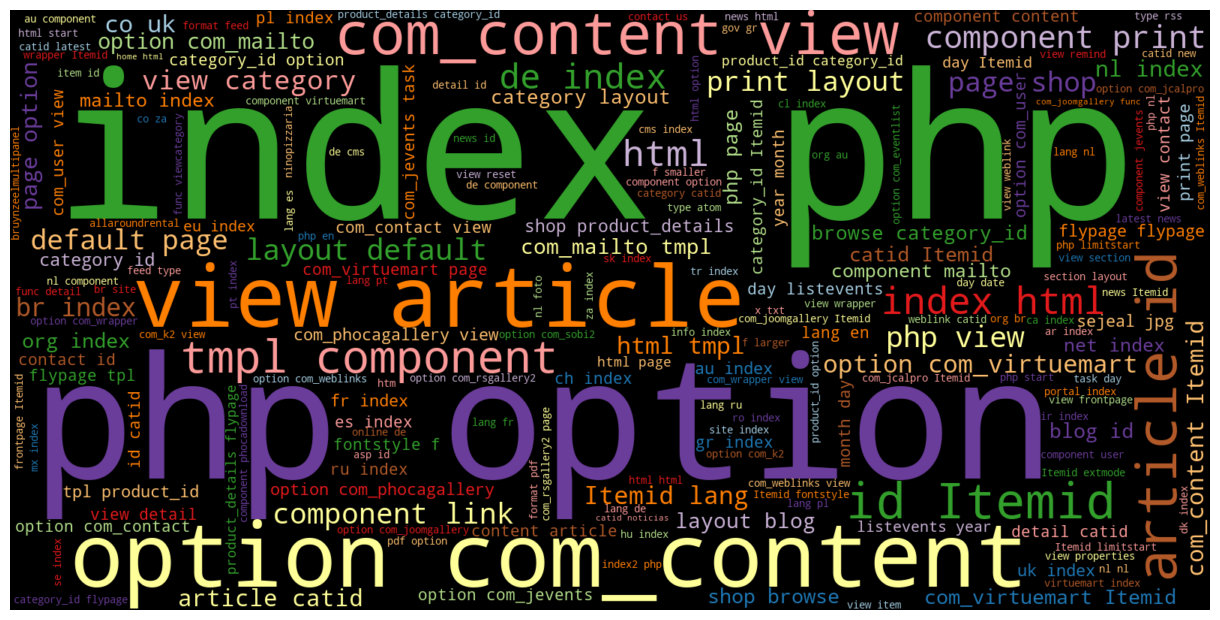

In [11]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width = 1600 , height = 800 , colormap = "Paired").generate(deface_url)
plt.figure(figsize=(12,13), facecolor ='w')
plt.imshow(wordcloud , interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

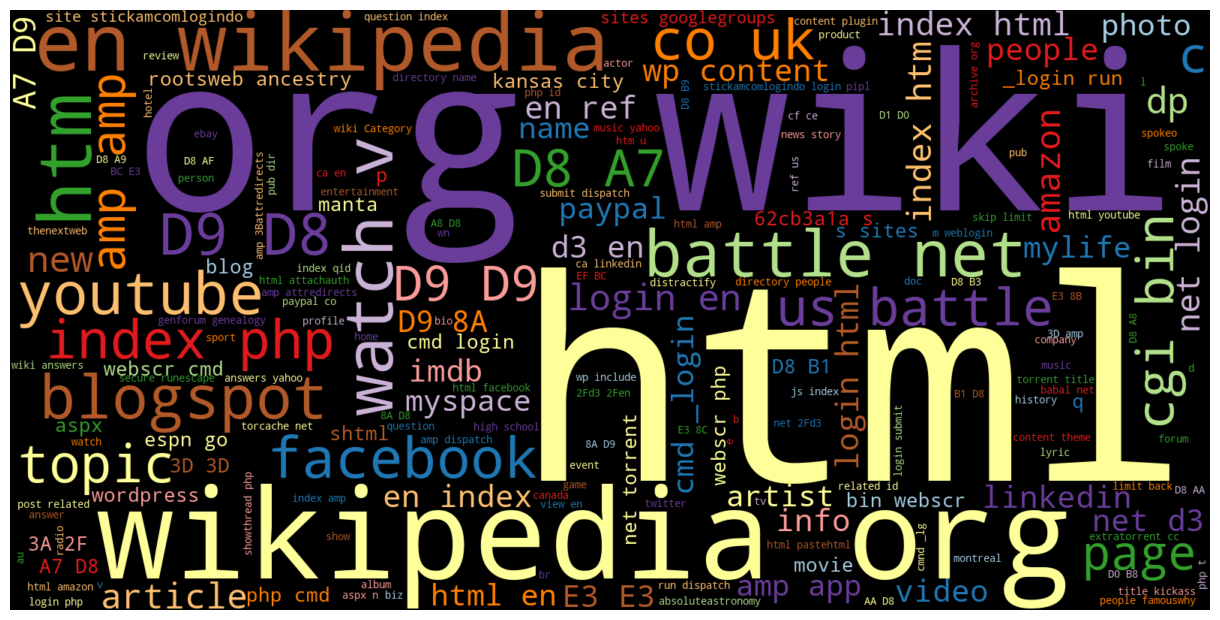

In [12]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width = 1600 , height = 800 , colormap = "Paired").generate(benign_url)
plt.figure(figsize=(12,13), facecolor ='w')
plt.imshow(wordcloud , interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Check missing DATA

In [13]:
print(df.isnull().sum())

url     0
type    0
dtype: int64


In [14]:
#convert type into number form

In [15]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['type'])

In [16]:
df

,url,type,label_encoded
0,br-icloud.com.br,phishing,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3


Feature Extraction

In [17]:
suspicious_keywords = ['login', 'signin', 'verify', 'update', 'banking', 'account', 'secure', 'ebay', 'paypal']

# feature extraction function
def extract_features(url):
    features = {}

    # Total length of the URL
    features['url_length'] = len(url)

    # Number of digits in the URL
    features['num_digits'] = sum(c.isdigit() for c in url)

    # Number of special characters (punctuation) in the URL
    features['num_special_chars'] = sum(c in string.punctuation for c in url)

    # Number of subdomains (i.e., number of dots minus one)
    features['num_subdomains'] = url.count('.') - 1

    features['has_ip'] = 1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else 0

    # Whether the URL uses HTTPS
    features['has_https'] = int('https' in url.lower())

    # Number of query parameters (indicated by '?')
    features['num_params'] = url.count('?')

    # Number of URL fragments (indicated by '#')
    features['num_fragments'] = url.count('#')

    # Total number of slashes in the URL
    features['num_slashes'] = url.count('/')

    # Whether the URL contains any suspicious keywords
    features['has_suspicious_words'] = int(any(word in url.lower() for word in suspicious_keywords))

    tld = url.split('.')[-1]
    features['tld_length'] = len(tld)

    # Whether the TLD is a common one
    features['is_common_tld'] = int(tld in ['com', 'org', 'net', 'edu', 'gov'])

    # Whether the URL contains hexadecimal encoding (e.g., "%2F")
    features['has_hex'] = int(bool(re.search(r'%[0-9a-fA-F]{2}', url)))

    # Whether the URL has repeated characters (e.g., "aaaaa", "1111")
    features['repeated_chars'] = int(bool(re.search(r'(.)\1{3,}', url)))

    return pd.Series(features)

# Apply feature extraction
features_df = df['url'].apply(extract_features)
df = pd.concat([df, features_df], axis=1)
df.head()

,url,type,label_encoded,url_length,num_digits,num_special_chars,num_subdomains,has_ip,has_https,num_params,num_fragments,num_slashes,has_suspicious_words,tld_length,is_common_tld,has_hex,repeated_chars
0,br-icloud.com.br,phishing,3,16,0,3,1,0,0,0,0,0,0,2,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,1,5,1,0,0,0,0,2,0,4,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,1,5,1,0,0,0,0,3,0,3,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,7,18,2,0,0,1,0,3,0,53,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,22,14,1,0,0,1,0,3,0,198,0,0,0


Feature Coorelation

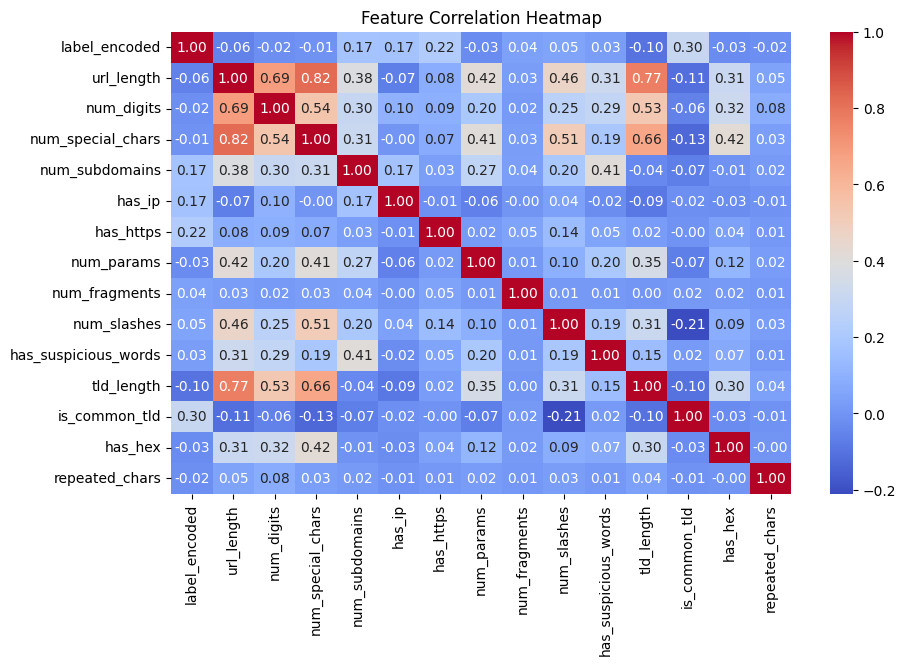

In [18]:
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Feature Correlation Heatmap')
plt.show()

Model training and evaluation

In [19]:
X = df.drop(columns =['url','type', 'label_encoded'])
y = df['label_encoded']

X_train,X_test,y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 42)

models ={
    'XGBoost': XGBClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
}

accuracies= {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"Accuracy for {name}: {acc:4f}")
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names= label_encoder.classes_))
    print("\n")

Training XGBoost...
Accuracy for XGBoost: 0.908384
Classification Report for XGBoost:
              precision    recall  f1-score   support

      benign       0.93      0.95      0.94     85778
  defacement       0.88      0.92      0.90     19104
     malware       0.97      0.87      0.91      6521
    phishing       0.81      0.71      0.75     18836

    accuracy                           0.91    130239
   macro avg       0.90      0.86      0.88    130239
weighted avg       0.91      0.91      0.91    130239



Training Random Forest...
Accuracy for Random Forest: 0.926458
Classification Report for Random Forest:
              precision    recall  f1-score   support

      benign       0.95      0.96      0.95     85778
  defacement       0.92      0.94      0.93     19104
     malware       0.97      0.93      0.95      6521
    phishing       0.81      0.77      0.79     18836

    accuracy                           0.93    130239
   macro avg       0.91      0.90      0.91    

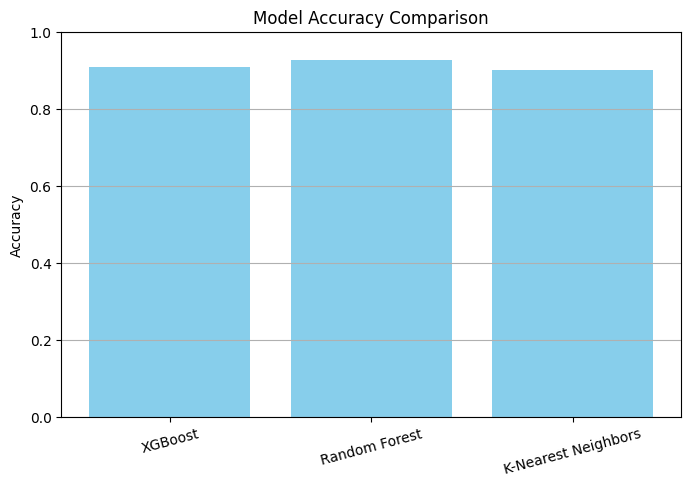

In [20]:
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()